In [20]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

import tensorflow as tf
from tensorflow import keras
    

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
from IPython.display import display
# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22

from pylab import *
from scipy.stats import linregress
from pathlib import Path

import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)



In [2]:
import re
import sklearn
import keras


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

tf.config.experimental.list_physical_devices()
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")


No GPU was detected. Neural nets can be very slow without a GPU.


import of data

In [3]:
DATA=pd.read_csv('./Molecules-data/smiles_prop.csv',sep='\t')
display(DATA)
DATA=DATA[0:5000]                           #we take the 5000th first value of data


,Smiles,Molar Mass / g.mol-1,log(P),TPSA
0,C[C@@]1(c2ccccc2)OC(C(=O)[O-])=CC1=O,217.050632,0.13490,66.43
1,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,289.077264,2.03010,66.40
2,CCC[S@](=O)c1ccc2[nH]/c(=N/C(=O)OC)[nH]c2c1,281.083412,1.68070,87.31
3,CCC[S@](=O)c1ccc2[nH]/c(=N\C(=O)OC)[nH]c2c1,281.083412,1.68070,87.31
4,C=CCN1C(=O)[C@@H](CC(C)C)NC1=S,212.098334,1.30380,32.34
...,...,...,...,...
499993,O=Cc1coc2c(ccc3ccccc32)c1=O,224.047344,2.75870,47.28
499994,CC(C)(C)n1cc(C(=O)c2ccc3ccccc3c2O)cn1,294.136828,3.72790,55.12
499995,COc1ccc(S(=O)(=O)n2[nH]c(=O)c(CCO)c2C)cc1,312.077993,0.26522,101.39
499996,Cc1c(CCO)c(=O)[nH]n1S(=O)(=O)c1ccc(F)cc1,300.058006,0.39572,92.16


### fonction to convert smiles as tokens

the goal is to convert a smiles in token to read it better :
example : smiles = [C[C@H](Cc1ccccc1)[NH2+][C@@H](C#N)c1ccccc1]
smiles_tokenized = 'C','[C@H]','(','C','c','1','c','c','c','c','c','1',')','[NH2+]','[C@@H]','(','C','#','N',')','c','1','c','c','c','c','c','1'

In [4]:
def tokenize(data, with_begin_and_end=True):        # fonction to tokenize
    """Tokenizes a SMILES string."""
    REGEXPS = {                                           # group of characters that we want to tokenize
            "brackets": re.compile(r"(\[[^\]]*\])"),
            "2_ring_nums": re.compile(r"(%\d{2})"),
            "brcl": re.compile(r"(Br|Cl)")
        }
    
    REGEXP_ORDER = ["brackets", "2_ring_nums", "brcl"]

    def split_by(data, regexps):
        if not regexps:
            return list(data)
        regexp = REGEXPS[regexps[0]]
        splitted = regexp.split(data)
        tokens = []
        for i, split in enumerate(splitted):
            if i % 2 == 0:
                tokens += split_by(split, regexps[1:])
            else:
                tokens.append(split)
        return tokens

    tokens = split_by(data, REGEXP_ORDER)
    
    if with_begin_and_end:
        tokens = ["^"] + tokens + ["$"]
    return tokens

convertion des smiles en token


In [5]:
list_smiles_tokeniser=[]
for i in DATA['Smiles'] :
    smiles_tokeniser=tokenize(i, with_begin_and_end=False)
    list_smiles_tokeniser=list_smiles_tokeniser+[smiles_tokeniser]
print(type(list_smiles_tokeniser[0]))
print(list_smiles_tokeniser[0])

<class 'list'>
['C', '[C@@]', '1', '(', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', ')', 'O', 'C', '(', 'C', '(', '=', 'O', ')', '[O-]', ')', '=', 'C', 'C', '1', '=', 'O']


building of dictionnarie to convert smiles_tokennized in picture

In [6]:
# Dictionnarie
comptage = {}

mot_le_plus_long = ""
longueur_maximale = 0

# Cycle through each sentence in the list
for phrase in list_smiles_tokeniser:
    # Cycle through each character in the list tokken
    for caractere in phrase:
        # If the character is already in the dictionary, increment the count
        if caractere in comptage:
            comptage[caractere] += 1
        # Otherwise, add the character to the dictionary with a count of 1
        else:
            comptage[caractere] = 1

    if len(phrase) > longueur_maximale:
        longueur_maximale = len(phrase)
        mot_le_plus_long = phrase
    
dictionnaire = list(comptage.keys())

for caractere, nombre in comptage.items():
    print(f"there is {nombre} '{caractere}'")

print(f"whether {len(comptage)} tokken")

print("dictionnarie :", dictionnaire)

print(f"the longuest word is'{mot_le_plus_long}' with {longueur_maximale} tokken.")

there is 24255 'C'
there is 61 '[C@@]'
there is 13626 '1'
there is 14490 '('
there is 44481 'c'
there is 6836 '2'
there is 14490 ')'
there is 9389 'O'
there is 7033 '='
there is 601 '[O-]'
there is 6 '[S@@]'
there is 5363 'N'
there is 3 '[S@]'
there is 311 '[nH]'
there is 900 '/'
there is 117 '\'
there is 1041 '[C@@H]'
there is 961 'S'
there is 1092 '[C@H]'
there is 447 '[NH+]'
there is 180 '[NH2+]'
there is 303 '#'
there is 2450 'n'
there is 409 '-'
there is 82 '[C@]'
there is 228 '[N+]'
there is 1498 '3'
there is 77 '[NH3+]'
there is 1046 'Cl'
there is 328 'o'
there is 251 'Br'
there is 174 '4'
there is 417 's'
there is 17 'I'
there is 684 'F'
there is 54 '[nH+]'
there is 29 '[n+]'
there is 14 '5'
there is 1 '[P@@]'
there is 9 'P'
there is 38 '[N-]'
there is 4 '[H]'
there is 25 '[S-]'
there is 6 '[n-]'
there is 1 '[PH]'
whether 45 tokken
dictionnarie : ['C', '[C@@]', '1', '(', 'c', '2', ')', 'O', '=', '[O-]', '[S@@]', 'N', '[S@]', '[nH]', '/', '\\', '[C@@H]', 'S', '[C@H]', '[NH+]', '

### convert the token list in pixel matrixe
We convert the smiles tokkenised in picture.
all picktures must have the same dimention.

In [7]:
list_Binaire=[]
taille_dictionnaire=len(dictionnaire)
index_dict = {caractere: idx for idx, caractere in enumerate(dictionnaire)}
for mot in list_smiles_tokeniser:
    encodage_binaire = np.zeros((longueur_maximale, taille_dictionnaire), dtype=int)
    for i, caractere in enumerate(mot):
        if caractere in index_dict:
            encodage_binaire[i, index_dict[caractere]] = 1
    list_Binaire.append(np.array(encodage_binaire))
list_Binaire=np.array(list_Binaire)


In [8]:
test=45
print(dictionnaire)
print(DATA['Smiles'][test])
print((np.array(list_Binaire[test])))
print((list_Binaire[test]))
print(len(list_Binaire[test]))

['C', '[C@@]', '1', '(', 'c', '2', ')', 'O', '=', '[O-]', '[S@@]', 'N', '[S@]', '[nH]', '/', '\\', '[C@@H]', 'S', '[C@H]', '[NH+]', '[NH2+]', '#', 'n', '-', '[C@]', '[N+]', '3', '[NH3+]', 'Cl', 'o', 'Br', '4', 's', 'I', 'F', '[nH+]', '[n+]', '5', '[P@@]', 'P', '[N-]', '[H]', '[S-]', '[n-]', '[PH]']
OC[C@@H](O)COc1ccc(Cl)cc1
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
50


picture of molecule

,smiles,Log(P),BINAIRE,ROMol
0,C[C@@]1(c2ccccc2)OC(C(=O)[O-])=CC1=O,0.13490,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
1,O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO,2.03010,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",
2,CCC[S@](=O)c1ccc2[nH]/c(=N/C(=O)OC)[nH]c2c1,1.68070,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
3,CCC[S@](=O)c1ccc2[nH]/c(=N\C(=O)OC)[nH]c2c1,1.68070,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
4,C=CCN1C(=O)[C@@H](CC(C)C)NC1=S,1.30380,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
...,...,...,...,...
4995,CCn1cnc2c(=O)[nH][nH]c(=O)c21,-0.56720,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
4996,CCCc1ccc(OCC(=O)Nc2nccs2)cc1,3.11310,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
4997,CCn1c(=O)c2c(c3ccccc31)Oc1ccc(C)cc1N=C2C,4.57622,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",
4998,C[C@@]12CCC[C@](C)(C(=O)[O-])[C@@H]1CCc1ccc(O)...,2.15240,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",

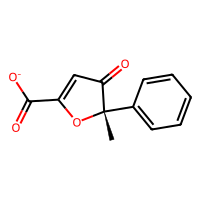
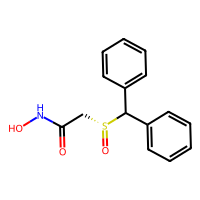
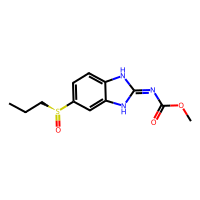
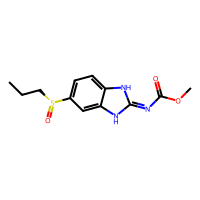
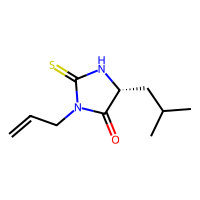
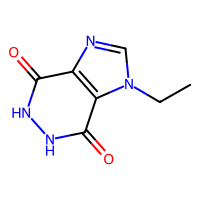
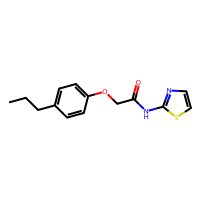
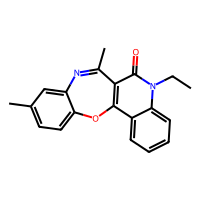
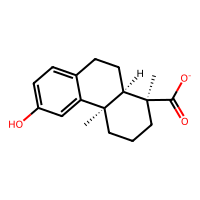
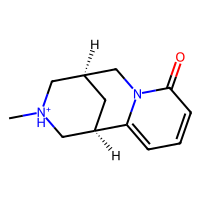

OC[C@@H](O)COc1ccc(Cl)cc1
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

['C', '[C@@]', '1', '(', 'c', '2', ')', 'O', '=', '[O-]', '[S@@]', 'N', '[S@]', '[nH]', '/', '\\', '[C@@H]', 'S', '[C@H]', '[NH+]', '[NH2+]', '#', 'n', '-', '[C@]', '[N+]', '3', '[NH3+]', 'Cl', 'o', 'Br', '4', 's', 'I', 'F', '[nH+]', '[n+]', '5', '[P@@]', 'P', '[N-]', '[H]', '[S-]', '[n-]', '[PH]']


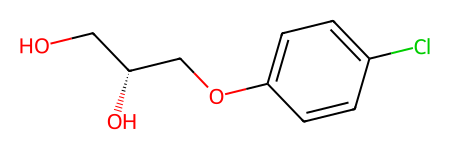

In [9]:
#creat data fram

smiles1 = DATA['Smiles'].values
TEMP = DATA['log(P)'].values
listnom = list_Binaire.tolist()
DATAML_BINAIRE= pd.DataFrame({"smiles": smiles1, "Log(P)":TEMP,'BINAIRE': listnom})

#add picture of molecule 

PandasTools.AddMoleculeColumnToFrame(DATAML_BINAIRE, smilesCol="smiles")
PandasTools.RenderImagesInAllDataFrames(True)

display(DATAML_BINAIRE)



test2=45

print(DATAML_BINAIRE["smiles"][test2])
print(list_Binaire[test2])
print()
molecule = DATAML_BINAIRE["ROMol"][test2]
print (dictionnaire)
molecule

displaying images in pixel format

In [10]:
from PIL import Image

largeur = len(dictionnaire)
hauteur = longueur_maximale

image = Image.new('L', (largeur, hauteur), 500)  # 255 est le blanc

test3=45

# Remplir l'image
for y, ligne in enumerate(list_Binaire[test3]):
    for x, valeur in enumerate(ligne):
        if valeur == 1:
            image.putpixel((x, y), 0)  # 0 est le noir




print(dictionnaire)
print(DATAML_BINAIRE['smiles'][test3])
#image.save(chemin_fichier)
# Afficher l'image (facultatif)
image.show()

['C', '[C@@]', '1', '(', 'c', '2', ')', 'O', '=', '[O-]', '[S@@]', 'N', '[S@]', '[nH]', '/', '\\', '[C@@H]', 'S', '[C@H]', '[NH+]', '[NH2+]', '#', 'n', '-', '[C@]', '[N+]', '3', '[NH3+]', 'Cl', 'o', 'Br', '4', 's', 'I', 'F', '[nH+]', '[n+]', '5', '[P@@]', 'P', '[N-]', '[H]', '[S-]', '[n-]', '[PH]']
OC[C@@H](O)COc1ccc(Cl)cc1


### Useful fonction for machine learning


In [11]:
from pathlib import Path

IMAGES_PATH = Path() / "ML-SavedFigures"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

MODELS_PATH = Path() / "ML-Savedmodels"
MODELS_PATH.mkdir(parents=True, exist_ok=True)

def get_var_name(arg):
    return [k for k,v in globals().items() if v == arg]

def save_fig(fig_id, IMAGES_PATH=".", tight_layout=True, fig_extension="png", resolution=300):
    '''
    saves a figure to a given subfolder, that will be created if it does not exist
    input:
        - fig_id = name of the figure, without an extension
        - IMAGES_PATH = pathway to the folder. Default: "."
        - tight_layout = boolean. Automatically adjusts subplot params so that the subplot(s) fits in to the figure area. Default: True
        - fig_extension = image type. Default: png
        - resolution = resolution of the figure, in dpi. Default: 300
    '''
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

def saveModel(model, model_id, MODELS_PATH=".", model_extension="keras"):
    '''
    saves a model to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: keras
    '''
    path = MODELS_PATH / f"{model_id}.{model_extension}"
    model.save(path)
    return

def plotModel(model, model_id, MODELS_PATH=".", fig_extension="png", resolution=300,
              show_shapes=True, show_layer_names=True, show_layer_activations=True):
    '''
    saves a model plot to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: png
    '''
    from tensorflow.keras.utils import plot_model
    from matplotlib.pyplot import plot
    path = MODELS_PATH / f"{model_id}.{fig_extension}"
    plot_model(model, to_file=path, dpi=resolution, show_shapes=show_shapes, 
               show_layer_names=show_layer_names, show_layer_activations=show_layer_activations)
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

def plotFashionToGrid(X, y, fashion_names, nrows=5, ncols=8, startFrom=0, yActual=None, saveFig = False, IMAGES_PATH=".",save_imgs=False, fig_extension="png"):
    '''
    plots nrows x ncols images with plt.imshow(), with their label as title
    input:
        - X = array with nimg b&w images coded as (npix,npix). Size = (nimg, npix, npix)  
        - y = 1D array made of nimg integers = class number
        - fashion_names = array with the corresponding class names
        - nrows, ncols = dimension of the plot grid (nrows x ncols must be <= nimg)
        - startFrom = index of the first image that will be shown
        - yActual = only useful when evaluating a prediction. It will contain the
          actual integer labels of the images
          In this case, y must be set to the value predicted by the model
          When a prediction is wrong, the label will be shown in red
        - saveFig = saves the figure to IMAGES_PATH
        - IMAGES_PATH = pathway to save images. Default: "."
    '''
    from matplotlib import pyplot as plt
    from PIL import Image

    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    nimg = nrows * ncols
    if nimg > len(y) - startFrom:
        print(f"Sample size = {len(y)}. Cannot plot {nrows} x {ncols} = {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {len(y) - nimg}")
        startFrom = len(y) - nimg
    for row in range(nrows):
        for col in range(ncols):
            index = ncols * row + col + startFrom
            plt.subplot(nrows, ncols, index + 1 - startFrom) # the third argument represents the index of the subplot that will be used
            plt.imshow(X[index], cmap="binary", interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
            plt.axis('off')
            colorTitle = 'black'
            if yActual is not None and yActual[index] != y[index]:
                colorTitle='red'
            plt.title(fashion_names[y[index]],color=colorTitle)
            if save_imgs:
                file = IMAGES_PATH + f"img4 were given{index:06d}.{fig_extension}" 
                I8 = (((X[index] - X[index].min()) / (X[index].max() - X[index].min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save(file)

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_grid",fig_extension=fig_extension)
    plt.show()
    return

def smiles_to_image(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Draw.MolToImage(mol)


def compareReconstructionsWithOriginalImages(model, imgDataset, smilesList, nimg, startFrom=0, saveFig = False, IMAGES_PATH="."):
    
    selectedImg = imgDataset[startFrom:startFrom+nimg]
    reconstrucedImg = model.predict(selectedImg)
    selectedSmiles = smilesList[startFrom:startFrom + nimg]
    
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(8, nimg*4)) #1 row for actual images, 1 row for reconstructed images
    if nimg > imgDataset.shape[0] - startFrom:
        print(f"Dataset size = {imgDataset.shape[0]}. Cannot plot {nimg} images, with startFrom set as {startFrom}")
        print(f"startFrom automatically setup to {imgDataset.shape[0] - nimg}")
        startFrom = imgDataset.shape[0] - nimg
    for img_index in range(nimg):
        
        plt.subplot(nimg, 3, 3*img_index+1) # the third argument represents the index of the subplot that will be used
        plt.imshow(selectedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')

        
        plt.subplot(nimg, 3, 3*img_index+2) # the third argument represents the index of the subplot that will be used
        plt.imshow(reconstrucedImg[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) # the data X is resampled to the pixel size of the image on the figure canvas, using the "nearest" interpolation method
        plt.axis('off')

        plt.subplot(nimg, 3, 3 * img_index + 3)
        mol_img = smiles_to_image(selectedSmiles[img_index])
        plt.imshow(mol_img)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    if (saveFig):
        save_fig(IMAGES_PATH,"fashion_mnist_autoencoder")
    plt.show()
    return

def ShowLatentSpaceRepresentation(encoder, decoder, ae, imgDataset, img_index):
    img = imgDataset[img_index].reshape(1,imgDataset.shape[1],imgDataset.shape[2])
    LatentSpaceRepresentation = encoder.predict(img)
    Reconstructed_img = decoder.predict(LatentSpaceRepresentation)
    print(Reconstructed_img.shape)
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=12)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.figure(figsize=(24, 2))
    plt.subplots(1, 3, gridspec_kw={"width_ratios": [1, 2, 1]})
    plt.subplot(1, 3, 1) 
    plt.imshow(imgDataset[img_index], cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(LatentSpaceRepresentation, cmap='binary', interpolation="nearest")
    plt.yticks([])
    plt.subplot(1, 3, 3) 
    plt.imshow(Reconstructed_img.reshape(67,22), cmap='binary', interpolation="nearest",vmin=0.0, vmax=1.0) 
    plt.axis('off')
    plt.show()
    return LatentSpaceRepresentation, Reconstructed_img

### spliting of data

In [12]:

label_to_model = DATAML_BINAIRE['Log(P)']
smiles=DATAML_BINAIRE['smiles']
print(list_Binaire)
print(smiles)


#split the data for training

(   X_train,
    X_valid,
    y_train,
    y_valid,
    smiles_train,
    smiles_valid,
) = train_test_split(list_Binaire, label_to_model, np.array(smiles), test_size=0.2, random_state=SEED)



X_train.reshape(len(X_train),len(dictionnaire),longueur_maximale)          #convert the Data 

print(X_train.shape)
print(y_train.shape)
# NBVAL_CHECK_OUTPUT

print("Training data size:", len(X_train))
print("Test data size:", len(X_valid))
print(len(smiles_valid), label_to_model, np.array(smiles), test_size=0.2, random_state=SEED)



X_train.reshape(len(X_train),len(dictionnaire),longueur_maximale)          #convert the Data 

print(X_train.shape)
print(y_train.shape)
# NBVAL_CHECK_OUTPUT

print("Training data size:", len(X_train))
print("Test data size:", len(X_valid))
print(len(smiles_valid))

[[[1 0 0 ... 0 0 0]
  [0 1 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[1 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 1 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
0                    C[C@@]1(c2ccccc2)OC(C(=O)[O-])=CC1=O
1                    O=C(C[S@@](=O)C(c1ccccc1)c1ccccc1)NO
2             CCC[S@](=O)c1ccc2[nH]/c(=N/C(=O)OC)[nH]c2c1
3             CCC[S@](=O)c1ccc2[nH]/c(=N\C(=O)OC)[nH

TypeError: 'test_size' is an invalid keyword argument for print()

In [13]:
imgW = (np.array(X_train[0])).shape[1]
imgH = (np.array(X_train[0])).shape[0]



print(imgW ,imgH)
print(imgW*imgH)


45 50
2250


model de machine learning


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       250,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,350 (977.93 KB)

 Trainable params: 250,350 (977.93 KB)

 Non-trainable params: 0 (0.00 B)

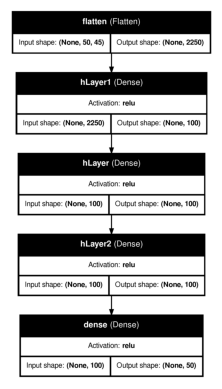

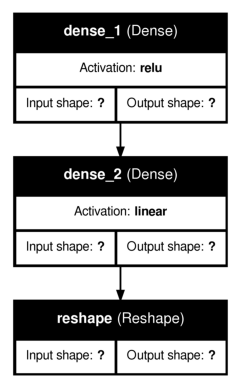

In [14]:
tf.keras.backend.clear_session()

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[imgH,imgW]),
    tf.keras.layers.Dense(100, activation="relu",name='hLayer1'),
    tf.keras.layers.Dense(100, activation="relu", name='hLayer'),
    tf.keras.layers.Dense(100, activation="relu", name='hLayer2'),
    tf.keras.layers.Dense(50, activation="relu"),
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(imgW * imgH),
    tf.keras.layers.Reshape([imgH, imgW])
])

stacked_aeModel = tf.keras.Sequential([stacked_encoder, stacked_decoder])

#t4pPC.centerTitle("Summary of the model")
stacked_encoder.build()
stacked_decoder.build()
stacked_aeModel.build()
stacked_aeModel.summary()

#t4pPC.centerTitle("Plot models")
plotModel(stacked_encoder, "StackedEncoder", MODELS_PATH=MODELS_PATH)
print()
plotModel(stacked_decoder, "StackedDecoder", MODELS_PATH=MODELS_PATH)

In [15]:
stacked_aeModel.compile(loss="mse", optimizer="nadam")

In [16]:
print(X_train.shape)
history_ae = stacked_aeModel.fit(X_train, X_train, epochs=50,
                         validation_data=(X_valid, X_valid))

(4000, 50, 45)
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0117 - val_loss: 0.0089
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━

In [17]:
from varname import nameof
file = MODELS_PATH / f"{nameof(stacked_aeModel)}.keras"
stacked_aeModel.save(file)

file = MODELS_PATH / f"{nameof(stacked_encoder)}.keras"
stacked_encoder.save(file)

file = MODELS_PATH / f"{nameof(stacked_decoder)}.keras"
stacked_decoder.save(file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


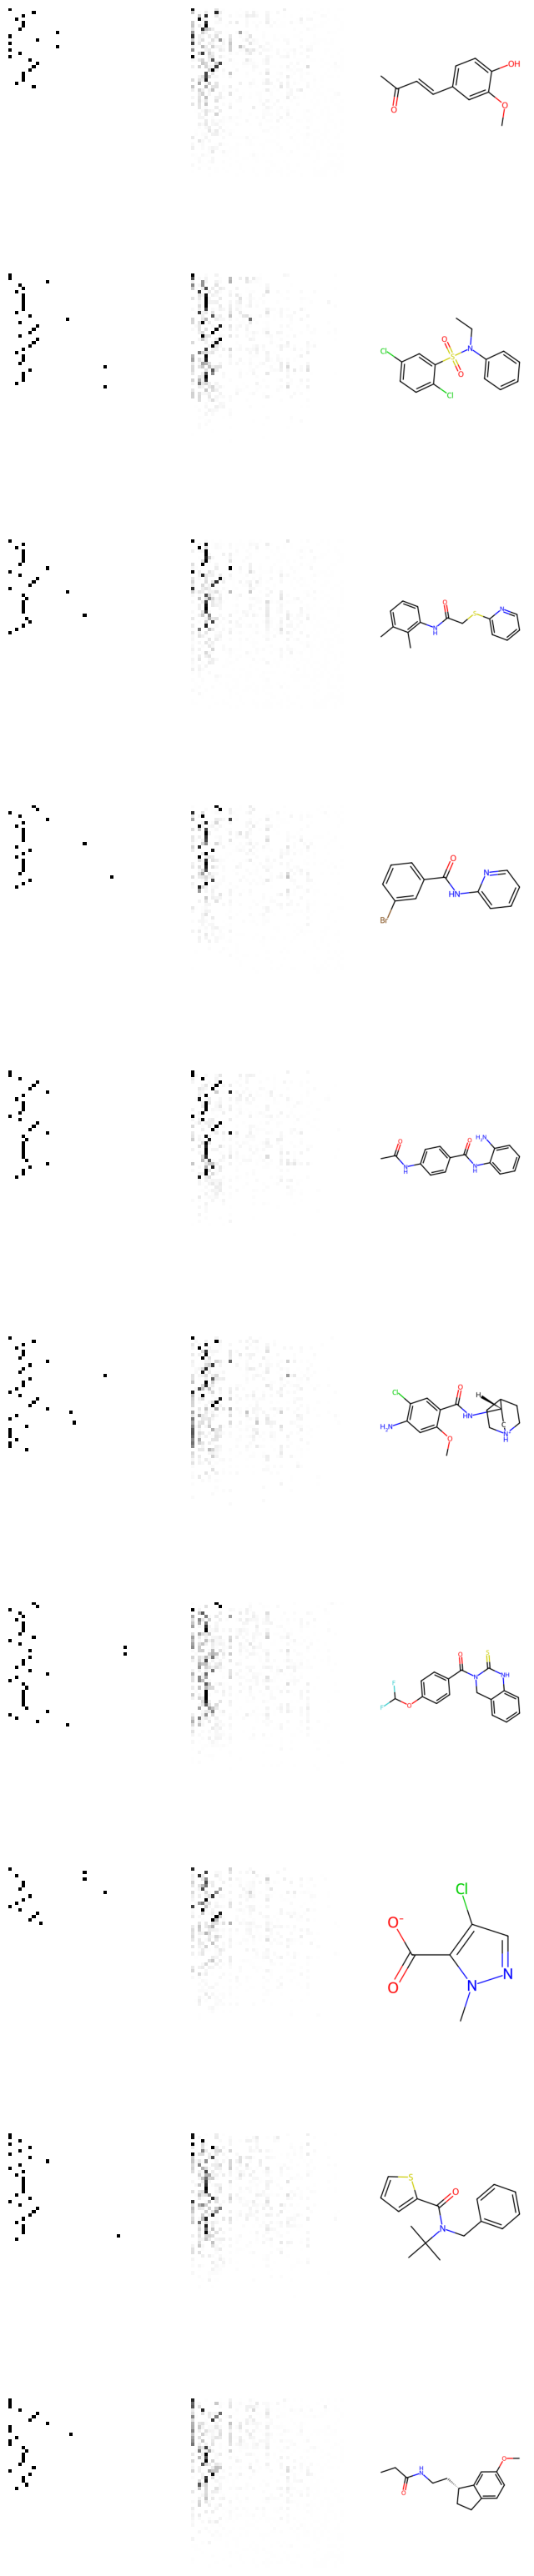

In [21]:
compareReconstructionsWithOriginalImages(stacked_aeModel,X_valid,smiles_valid,10)

show talent space


In [22]:
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_train)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [24]:
import pandas as pd
import plotly.express as px
import molplotly

Z = X_valid_2D.copy()
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
cm = 1/2.54

temp_df = pd.DataFrame({
    'X': Z[:, 0],
    'Y': Z[:, 1],
    'Log(P)': y_train,
    'smiles': smiles_train,
})



# Créer le scatter plot avec plotly
fig = px.scatter(temp_df, x='X', y='Y', color='Log(P)', hover_data=['smiles'])

fig.update_layout(
    width=800,  # Ajustez la largeur si nécessaire
    height=800,  # Ajustez la hauteur si nécessaire
    xaxis=dict(scaleanchor='y', scaleratio=2),
    yaxis=dict(scaleanchor='x', scaleratio=2)
)
# Ajouter des molécules avec molplotly
app = molplotly.add_molecules(
    fig=fig,
    df=temp_df,
    smiles_col='smiles',
    title_col='Log(P)'
)

# Exécuter l'application
app.run(mode='inline', port=8767, height=1600)